In [15]:
import torch
import numpy as np
from tqdm import tqdm, trange
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import os
from huggingface_hub import login
import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
import json
import einops
from sklearn.exceptions import ConvergenceWarning
import warnings
plt.rcParams.update({
    'font.size': 6,               # Default text size
    'axes.titlesize': 7,          # Title size for axes
    'axes.labelsize': 7,          # Axis label size
    'xtick.labelsize': 6,         # X-axis tick label size
    'ytick.labelsize': 6,         # Y-axis tick label size
    'legend.fontsize': 6,         # Legend font size
    'figure.titlesize': 10,        # Overall figure title size
})
mapping = {'helix_a_b':'helix(a,b)', 'helix_ab': 'helix(a+b)', 'helix_a_b_ab': 'helix(a,b,a+b)', 'pca_27': '27dim PCA', 'pca_9': '9dim PCA', 'exchange': 'Layer Patch'}

In [2]:
# Load model# Set the token as an environment variable
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
full_model_name = 'EleutherAI/gpt-j-6B'#'meta-llama/Llama-3.1-8B'# #'EleutherAI/pythia-6.9b'## # #'google/gemma-2-9b'#'##
MODEL_NAME = full_model_name.split('/')[-1]
model = LanguageModel(full_model_name, device_map=device, torch_dtype=torch.bfloat16, dispatch=True)
remote = False
NLAYERS = model.config.num_hidden_layers
NHEADS = model.config.n_head

Some weights of the model checkpoint at EleutherAI/gpt-j-6B were not used when initializing GPTJForCausalLM: ['transformer.h.0.attn.bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.1.attn.bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.10.attn.bias', 'transformer.h.10.attn.masked_bias', 'transformer.h.11.attn.bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.12.attn.bias', 'transformer.h.12.attn.masked_bias', 'transformer.h.13.attn.bias', 'transformer.h.13.attn.masked_bias', 'transformer.h.14.attn.bias', 'transformer.h.14.attn.masked_bias', 'transformer.h.15.attn.bias', 'transformer.h.15.attn.masked_bias', 'transformer.h.16.attn.bias', 'transformer.h.16.attn.masked_bias', 'transformer.h.17.attn.bias', 'transformer.h.17.attn.masked_bias', 'transformer.h.18.attn.bias', 'transformer.h.18.attn.masked_bias', 'transformer.h.19.attn.bias', 'transformer.h.19.attn.masked_bias', 'transformer.h.2.attn.bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.20.attn.bi

In [3]:
def get_correct_df(mina = 0, maxa = 99):
    df = pd.read_pickle(f'data_addition/gen_math/data_addition_correct_{mina}_{maxa}.pkl')
    return df[df['correct'] == 1]

def get_df_sample(mina = 0, maxa = 99, num_sample = 1000, run = False):
    if run:
        df = get_correct_df(mina, maxa)
        df = df.sample(n=num_sample, random_state=42).reset_index(drop=True)
        # Save sampled dataframe
        save_path = f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl'
        df.to_pickle(save_path)
    return pd.read_pickle(f'data_addition/gen_math/data_addition_correct_sample_{mina}_{maxa}.pkl')

def gen_intervention(mina = 0, maxa = 99, samplesize = 1000, run = False):
    if run:
        df = get_df_sample(mina, maxa, run = False)
        # Create cartesian product of df with itself
        intervention_df = df.merge(df, how='cross', suffixes=('_original', '_intervened'))
        # Filter out cases where original answer equals intervened answer
        intervention_df = intervention_df[intervention_df['answer_original'] != intervention_df['answer_intervened']]
        # Take random sample of size samplesize
        if samplesize < len(intervention_df):
            intervention_df = intervention_df.sample(n=samplesize, random_state=42).reset_index(drop = True)
        # Save to pickle file
        intervention_df.to_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    intervention_df = pd.read_pickle(f'data/gen_math/ab_data_intervention_{mina}_{maxa}_sample{samplesize}_{MODEL_NAME}.pkl')
    return intervention_df

#gen_intervention(0,99)
#get_df_sample(run = False)

In [4]:
def get_model_components():
    save_dir = 'data_addition/ab_probing_data'
    data = torch.load(f'{save_dir}/raw_components_data.pt', weights_only=False)
    return data

def get_mlp_component(layer):
    data = get_model_components()
    return data['mlps'][layer]

def get_pca_component(layer, component_type = 'mlp'):
    assert component_type in ['attn', 'mlp', 'resid'], f"component_type must be one of ['attn', 'mlp', 'resid'], got {component_type}"
    with open(f'data_addition/ab_probing_data/pcas.pkl', 'rb') as f:
        data = pickle.load(f)
    return data[f'{component_type}_pcas'][layer], data['mlp_pca_objects'][layer]

def get_ab_vals():
    with open(f'data_addition/ab_probing_data/pcas.pkl', 'rb') as f:
        data = pickle.load(f)
    return data['a'], data['b'], data['a_b']

def create_features(a,b,a_b, bases = [2,5,10,100]):
    nums = np.array([a,b,a_b])
    feature_list = []
    for i, num in enumerate(nums):
        for base in bases:
            t_scaled = 2 * np.pi * num / base
            feature_list.extend([np.cos(t_scaled), np.sin(t_scaled)])
        feature_list.append(num / max(num))  # Add linear term for helix
    feature_list.append(np.ones(nums.shape[1])) # bias term
    helix_features = np.column_stack(feature_list)
    return helix_features

def get_feature_names(bases = [2,5,10,100], helix_type = 'helix_a_b_ab'):
    assert helix_type in ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], f"helix_type must be one of ['helix_ab', 'helix_a_b_ab', 'helix_a_b'], got {helix_type}"
    if helix_type == 'helix_ab':
        variables = ['a+b']
    elif helix_type == 'helix_a_b':
        variables = ['a', 'b']
    else:
        variables = ['a', 'b', 'a+b']
    feature_names = []
    for i in range(len(variables)):
        for base in bases:
            feature_names.extend([f'cos({variables[i]}|T = {base})', f'sin({variables[i]}|T = {base})'])
        feature_names.append(variables[i])
    feature_names.append('1')
    return feature_names # All features

data = get_model_components()
data.keys()

dict_keys(['attns', 'mlps', 'resids', 'attn_heads', 'a', 'b', 'a_b'])

# Helix Fitting

In [5]:
def helix_fit(helix_type, layer, bases = [2,5,10,100]):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    X_pca, pca_obj = get_pca_component(layer)
    a, b, a_b = get_ab_vals()
    X_original = get_mlp_component(layer)
    helix_features = create_features(a,b,a_b, bases)
    batch = helix_features.shape[1]//3
    if helix_type == 'helix_a_b':
        helix_features = helix_features[:, :2*batch]
        helix_features = np.concatenate([helix_features, helix_features[:, -1:]], axis=1)
    elif helix_type == 'helix_ab':
        helix_features = helix_features[:, -batch-1:]
    elif helix_type == 'helix_a_b_ab':
        helix_features = helix_features
    # Inverse transform PCA back to original space
    # Get first 27 PCA components and mean
    components_27 = pca_obj.components_[:27]
    mean = pca_obj.mean_
    # Reconstruct using only first 27 dimensions
    X_pca_27 = X_pca[:,:27]
    X_reconstructed = X_pca_27 @ components_27 + mean
    # Calculate MSE between original and reconstructed data
    reconstruction_mse = float(torch.mean((X_original - torch.tensor(X_reconstructed)) ** 2).item())
    #print(f"PCA Reconstruction MSE (27 dims): {reconstruction_mse}")
    weights_by_dim = []
    predictions = np.zeros_like(X_pca)
    models = []
    
    # Suppress convergence warnings during model fitting
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        for i in range(X_pca.shape[1]):
            model = LinearRegression(fit_intercept=False)
            #model = Lasso(alpha=0.01, fit_intercept=False)
            model.fit(helix_features, X_pca[:, i])
            models.append(model)
            weights_by_dim.append(model.coef_)
            predictions[:, i] = model.predict(helix_features)  # Predict on all data
            
    # Transform predictions back to original space using SVD components
    predictions_full_space =  pca_obj.inverse_transform(predictions)
    # Calculate MSE in original space
    mse = np.mean((predictions_full_space - X_original.numpy()) ** 2)
    A = np.stack(weights_by_dim, axis=-1)  # Stack weights to form the matrix A
    save_dir = f"data_addition/ab_mlps/{helix_type}_fits"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/mlp_L{layer}_helixfit_{MODEL_NAME}.pkl"
    #print(save_path)
    #print(save_path)
    with open(save_path, 'wb') as f:
        save_dict = {
            'a': a,
            'b':b,
            'a+b':a_b,
            'predictions_full': predictions_full_space,
            'pca_obj': pca_obj,
            'A': A
        }
        pickle.dump(save_dict, f)
    return reconstruction_mse, mse

#helix_fit('helix_a_b_ab', 19)

In [6]:
def fit_all_mlps():
    results = []
    bar = tqdm(range(NLAYERS))
    for layer in bar:
        for helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab']:
            pca_mse, helix_mse = helix_fit(helix_type,layer)
            results.append({
                'layer': layer,
                'pca_mse': pca_mse,
                'helix_mse': helix_mse,
                'fit_type': helix_type
            })
        bar.set_postfix(results[-1])
    
    save_dir = "data_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/fit_results_{MODEL_NAME}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)

#fit_all_mlps()             

# Test Helix Fit with Intervention

In [7]:
def get_full(layer):
    data = get_model_components()
    mlp = data['mlps'][layer]
    a,b,a_b = data['a'], data['b'], data['a_b']
    return a,b,a_b,mlp

def full_patch(nums, layer):
    a,b,a_b, reconstruction = get_full(layer)
    # Find matching indices using a for loop
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
            
    # Return tensor of predictions for matching indices
    return reconstruction[matching_indices]


In [8]:
def find_fit(helix_type, layer):
    save_dir = f"data_addition/ab_mlps/{helix_type}_fits"
    save_path = f"{save_dir}/mlp_L{layer}_helixfit_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_fit(nums, helix_type, layer):
    data = find_fit(helix_type, layer)
    a,b,a_b, allhss = data['a'],data['b'],data['a+b'], data['predictions_full']
    allnums = np.array([a,b,a_b])
    # Convert nums to 3xM array if needed
    nums = np.array(nums)
    # For each column in nums, find matching column in allnums
    matching_indices = []
    for i in range(nums.shape[1]):
        num_col = nums[:,i]
        # Find where this column appears in allnums
        for j in range(allnums.shape[1]):
            if np.array_equal(allnums[:,j], num_col):
                matching_indices.append(j)
                break
        else:
            raise ValueError(f"No matching column found in allnums for nums column {num_col}")
    # Return tensor of predictions for matching indices
    return torch.tensor(allhss[matching_indices])

#pca_projection([[32,77,32],[56,0,56],[88,77,88]], layer = 24, head = 10, npca = 27).shape

In [9]:
def calc_log_diff(original_logits, patched_logits, patched_answer_tokens):
    return patched_logits[range(len(patched_logits)), patched_answer_tokens] - original_logits[range(len(original_logits)), patched_answer_tokens]

def run_intervention(patch_dict, layer, batch_size = 100):
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()

    metrics = {'act_logdiff':[], 'path_logdiff': []}
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            intervened_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_intervened'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            patch_type = patch_dict['patch_type']
            if 'helix' in patch_type:
                # TODO: INCLUDE PATH PATCHING!!!!!!!!!
                exchange = get_fit(nums, patch_type, layer)
                exchange = exchange.clone().detach().to(device).to(dtype=torch.bfloat16)

            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(tokens, scan=False):
                    mlp_original = model.transformer.h[layer].mlp.output[:,-1].save()
                with tracer.invoke(intervened_tokens, scan=False):
                    if 'full' in patch_type:
                        exchange = model.transformer.h[layer].mlp.output[:,-1].save()
                with tracer.invoke(tokens, scan=False):
                    model.transformer.h[layer].mlp.output[:,-1] = exchange
                with tracer.invoke(tokens, scan=False):
                    model.transformer.h[-1].output[0][:,-1] += exchange - mlp_original
                output = model.output.save()
            original_logits, act_patch_logits, path_patch_logits = output.logits[:batch_size,-1], output.logits[2*batch_size:3*batch_size,-1], output.logits[3*batch_size:,-1],
            act_log_diff = calc_log_diff(original_logits, act_patch_logits, patched_answer_tokens)
            path_log_diff = calc_log_diff(original_logits, path_patch_logits, patched_answer_tokens)
            metrics['act_logdiff'].extend(act_log_diff.cpu().tolist())
            metrics['path_logdiff'].extend(path_log_diff.cpu().tolist())
    
    return {k: np.mean(v).item() for k,v in metrics.items()}

#patch_dict = {'patch_type':'helix_a_b_ab'}
#patch_dict = {'patch_type':'full'}
#run_intervention(patch_dict, layer = 3)
#

In [10]:
def intervene_all_mlps():
    results = []
    bar = tqdm(range(NLAYERS))
    for layer in bar:
        results_dict = {'layer':layer}
        for patch_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab', 'full']:
            ldiff = run_intervention({'patch_type':patch_type}, layer, batch_size = 100)
            results_dict[patch_type] = ldiff
        results.append(results_dict)
        bar.set_postfix(results_dict)
    
    save_dir = "data_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)


def get_intervention_results(helix_type):
    assert helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab'], f"helix_type must be one of ['a_b', 'ab', 'a_b_ab'], got {helix_type}"
    save_dir = "data_addition/ab_mlps"
    save_path = f"{save_dir}/intervention_results_{MODEL_NAME}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act = np.zeros((NLAYERS,))
    helix_path = np.zeros((NLAYERS,))
    full_act = np.zeros((NLAYERS,))
    full_path = np.zeros((NLAYERS,))
    for layer in range(NLAYERS):
        helix_act[layer] = results[layer][helix_type]['act_logdiff']
        helix_path[layer] = results[layer][helix_type]['path_logdiff']
        full_act[layer] = results[layer]['full']['act_logdiff']
        full_path[layer] = results[layer]['full']['path_logdiff']
    return helix_act, helix_path, full_act, full_path
#     helix_act = res_dict[f'{helix_type}']['act_logdiff']
#     full_act = res_dict['pca_500']['act_logdiff']
    
#     return helix_act, helix_path, full_act, full_path
#intervene_all_mlps()
#[0].shape

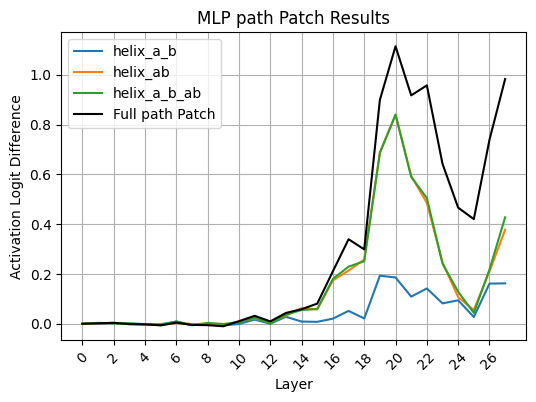

In [11]:
def plot_intervention_results(patch_type = 'act'):
    plt.figure(figsize=(6,4))
    for helix_type in ['helix_a_b', 'helix_ab', 'helix_a_b_ab']:
        if patch_type == 'act':
            helix_act, _,full_act, _ = get_intervention_results(helix_type)
        else: #path
            _, helix_act,_, full_act= get_intervention_results(helix_type)
        plt.plot(range(NLAYERS), helix_act, label = helix_type)
    plt.plot(range(NLAYERS), full_act, label = f'Full {patch_type} Patch', color = 'k')
    
    plt.title(f'MLP {patch_type} Patch Results')
    plt.xlabel('Layer')
    plt.ylabel('Activation Logit Difference')
    plt.legend()
    plt.xticks(range(0,NLAYERS,2), range(0,NLAYERS,2), rotation=45)
    plt.grid(True)
    save_dir = "figs_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{patch_type}_patch_results_{MODEL_NAME}.png")
    plt.show()
    plt.close()

plot_intervention_results('path')

# Evaluate Circuit

In [12]:
def get_topk_mlps(k):
    _,_, full_act, _ = get_intervention_results('helix_a_b')
    layers = list(range(NLAYERS))
    # Sort layers by their full_act values in descending order and get top k
    sorted_layers = [x for _,x in sorted(zip(full_act, layers), reverse=True)]
    return sorted_layers[:k]

def topk_mlp_act_patch(k,patch_type = 'total',batch_size = 100, verbose = False):
    assert patch_type in ['helix', 'total'], "patch_type must be either 'helix' or 'total'"
    topk_layers = get_topk_mlps(k)
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    metrics = {'act_logdiff':[]}
    with torch.no_grad():
        for step in range(0, len(df_subset), batch_size):
            # Take min of next batch_size elements to handle final incomplete batch
            batch_df = df_subset.iloc[step:min(step + batch_size, len(df))]
            original_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_original'].values]).to(device)
            corrupted_tokens = torch.stack([torch.tensor(x) for x in batch_df['q_tok_intervened'].values]).to(device)
            a, b, a_b = batch_df['a_intervened'].values, batch_df['b_intervened'].values, batch_df['answer_intervened'].values
            nums = np.array([a,b,a_b])
            original_answers, target_answers = batch_df['answer_original'].values, batch_df['answer_intervened'].values,
            patched_answer_tokens = torch.stack([torch.tensor(x[0]) for x in batch_df['answer_tok_intervened'].values]).to(device)
            exchanges = []
            if 'helix' in patch_type:
                for layer in range(NLAYERS):
                    exchanges.append(get_fit(nums, 'helix_a_b_ab', layer).clone().detach().to(device).to(dtype=torch.bfloat16))
            mlp_corrupted = []
            resid = []
            with model.trace(validate=False,remote=remote) as tracer:
                with tracer.invoke(original_tokens, scan=False):
                    pass
                with tracer.invoke(corrupted_tokens, scan=False):
                    for layer in range(NLAYERS):
                        mlp_corrupted.append(model.transformer.h[layer].mlp.output[:,-1].save())
                        resid.append(model.transformer.h[layer].output[0][:,-1].save())
                original_output = model.output.save()
            #print(resid[19].shape)
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens, scan=False):
                    for layer in topk_layers:
                        if patch_type == 'total':
                            model.transformer.h[layer].mlp.output[:,-1] = mlp_corrupted[layer]
                        else:
                            model.transformer.h[layer].mlp.output[:,-1] = exchanges[layer]
                    # pass
                intervened_output = model.output.save()
            original_logits, act_patch_logits = original_output.logits[:batch_size,-1], intervened_output.logits[:,-1]
            #print(act_patch_logits.shape, original_logits.shape)
            act_log_diff = calc_log_diff(original_logits, act_patch_logits, patched_answer_tokens)
            metrics['act_logdiff'].extend(act_log_diff.cpu().tolist())
    
    return {k: np.mean(v).item() for k,v in metrics.items()}


0.7 [19, 20, 21]
0.8 [19, 20, 21, 22]
0.9 [17, 18, 19, 20, 21, 22]
0.95 [14, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27]
0.99 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


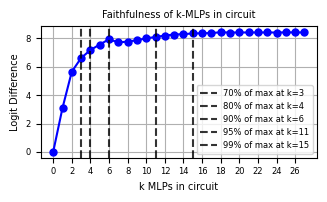

In [26]:
def topk_mlp_patches():
    results = []
    for k in tqdm(range(NLAYERS)):
        ldiff = topk_mlp_act_patch(k = k, verbose = False, patch_type = 'total')['act_logdiff']
        results.append(ldiff)
    
    # Save results to file
    save_dir = "data_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    np.save(f"{save_dir}/topk_mlp_act_patch_results_{MODEL_NAME}.npy", np.array(results))
    
    return results
def read_topk_mlp_patches():
    # Read results from file
    save_dir = "data_addition/ab_mlps"
    results = np.load(f"{save_dir}/topk_mlp_act_patch_results_{MODEL_NAME}.npy")
    return results
    

def plot_topk_mlp_patches():
    results = read_topk_mlp_patches()
    max_logdiff = max(results)
    
    plt.figure(figsize=(3.25,2))
    plt.plot(range(NLAYERS), results, marker='o', color = 'b', markersize = 5)
    
    # Add vertical lines at percentage thresholds
    thresholds = [0.70, 0.80, 0.90, 0.95, 0.99]
    for pct in thresholds:
        k, mlp_list = get_mlps_threshold(pct)
        print(pct, mlp_list)
        plt.axvline(x=k, linestyle='--', alpha=0.8, 
                   label=f'{int(pct*100)}% of max at k={k}', color = 'k')
    
    plt.grid(True)
    plt.xticks(range(0, NLAYERS, 2))
    plt.xlabel('k MLPs in circuit')
    plt.ylabel('Logit Difference')
    plt.title('Faithfulness of k-MLPs in circuit')
    plt.legend()
    
    save_dir = "figs_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"{save_dir}/topk_mlp_patching_thresholds_{MODEL_NAME}.png", bbox_inches = 'tight', dpi = 300)
    plt.show()
    plt.close()

def get_mlps_threshold(pct):
    results = read_topk_mlp_patches()
    max_logdiff = max(results)
    threshold = max_logdiff * pct
    # Find first k that exceeds threshold
    k = next(i for i, v in enumerate(results) if v >= threshold)
    return k, sorted(get_topk_mlps(k))

plot_topk_mlp_patches()

# Understanding Circuit Components

/tmp/ipykernel_1748607/1455508599.py:6: RuntimeWarning: invalid value encountered in divide
  de_ie = full_path/full_act


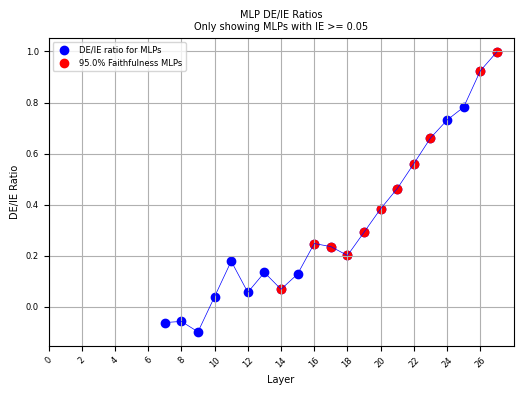

In [28]:
def plot_de_ie_mlp():
    thresh = 0.95
    k, circuit_mlps = get_mlps_threshold(thresh)
    plt.figure(figsize=(6,4))
    _, _,full_act, full_path = get_intervention_results('helix_ab')
    de_ie = full_path/full_act
    
    # Only plot points where full_act >= 0.05
    valid_indices = np.where(full_act >= 0.05)[0]
    
    plt.scatter(valid_indices, de_ie[valid_indices], label = f'DE/IE ratio for MLPs', marker = 'o', color = 'b')
    plt.plot(valid_indices, de_ie[valid_indices],  color = 'b', lw = 0.5)
    
    # Only plot circuit MLPs that meet threshold
    circuit_mlps = [mlp for mlp in circuit_mlps if full_act[mlp] >= 0.05]
    plt.scatter(circuit_mlps, de_ie[circuit_mlps], label = f'{thresh*100}% Faithfulness MLPs', marker = 'o', color = 'r')
    
    plt.title(f'MLP DE/IE Ratios\nOnly showing MLPs with IE >= 0.05')
    plt.xlabel('Layer')
    plt.ylabel('DE/IE Ratio')
    #plt.ylim(0, 1.1)
    plt.legend()
    plt.xticks(range(0,NLAYERS,2), range(0,NLAYERS,2), rotation=45)
    plt.grid(True)
    save_dir = "figs_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/mlp_de_ie_{MODEL_NAME}.png")
    plt.show()
    plt.close()

plot_de_ie_mlp()

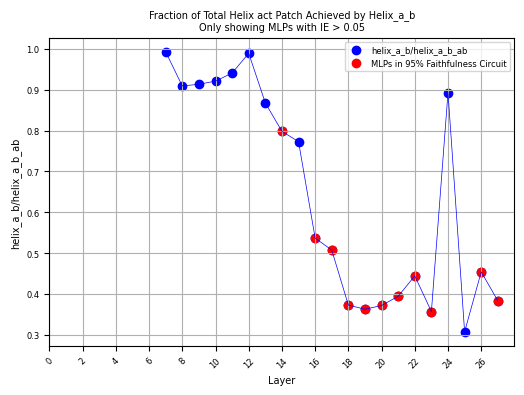

In [30]:
def plot_helix_a_b_frac(patch_type = 'act'):
    plt.figure(figsize=(6,4))
    if patch_type == 'act':
        helix_a_b, _,full_act, _ = get_intervention_results('helix_a_b')
        helix_all, _,_, _ = get_intervention_results('helix_a_b_ab')
        color = 'b'
        other_color = 'r'
    else:
        _, helix_a_b,full_act, _ = get_intervention_results('helix_a_b')
        _, helix_all,_, _ = get_intervention_results('helix_a_b_ab')
        color = 'r'
        other_color = 'b'
    thresh = 0.95
    k, circuit_mlps = get_mlps_threshold(thresh)
    fraction = helix_a_b/helix_all
    
    # Only show points where full_act > 0.05
    valid_indices = np.where(full_act > 0.05)[0]
    plt.scatter(valid_indices, fraction[valid_indices], label = 'helix_a_b/helix_a_b_ab', color=color)
    plt.plot(valid_indices, fraction[valid_indices], color=color, lw = 0.5)
    
    # Scatter MLPs in circuit with their corresponding fractions, but only if they meet threshold
    circuit_mlps = [mlp for mlp in circuit_mlps if full_act[mlp] > 0.05]
    circuit_fractions = [fraction[i] for i in circuit_mlps]
    plt.scatter(circuit_mlps, circuit_fractions, color=other_color, label=f'MLPs in {int(thresh*100)}% Faithfulness Circuit')
    
    plt.title(f'Fraction of Total Helix {patch_type} Patch Achieved by Helix_a_b\nOnly showing MLPs with IE > 0.05')
    plt.xlabel('Layer')
    plt.ylabel('helix_a_b/helix_a_b_ab')
    plt.legend()
    plt.grid(True)
    
    plt.xticks(range(0,NLAYERS,2), range(0,NLAYERS,2), rotation=45)
    
    save_dir = "figs_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/helix_a_b_fraction_{patch_type}_patch_{MODEL_NAME}.png")
    plt.show()
    plt.close()

plot_helix_a_b_frac('act')

/tmp/ipykernel_1748607/1326854537.py:15: RuntimeWarning: divide by zero encountered in divide
  fraction = np.minimum(helix_ab/full_act, 1.0)


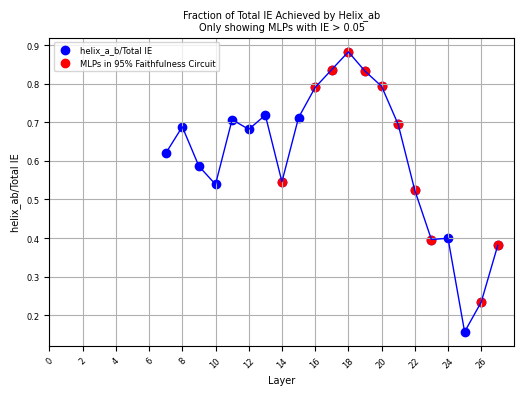

In [31]:
def plot_helix_ab_frac(patch_type = 'act'):
    plt.figure(figsize=(6,4))
    if patch_type == 'act':
        helix_ab, _,full_act, _ = get_intervention_results('helix_ab')
        color = 'b'
        target = 'IE'
        other_color = 'r'
    else:
        _, helix_ab,_, full_act = get_intervention_results('helix_ab')
        color = 'r'
        target = 'DE'
        other_color = 'b'
    thresh = 0.95
    k, circuit_mlps = get_mlps_threshold(thresh)
    fraction = np.minimum(helix_ab/full_act, 1.0)
    
    # Only show points where full_act > 0.05
    valid_indices = np.where(full_act > 0.05)[0]
    plt.scatter(valid_indices, fraction[valid_indices], label = f'helix_a_b/Total {target}', marker='o', color=color)
    plt.plot(valid_indices, fraction[valid_indices], color=color, lw = 1)
    
    # Scatter MLPs in circuit with their corresponding fractions, but only if they meet threshold
    circuit_mlps = [mlp for mlp in circuit_mlps if full_act[mlp] > 0.05]
    circuit_fractions = [fraction[i] for i in circuit_mlps]
    plt.scatter(circuit_mlps, circuit_fractions, color=other_color, label=f'MLPs in {int(thresh*100)}% Faithfulness Circuit')
    
    plt.title(f'Fraction of Total {target} Achieved by Helix_ab\nOnly showing MLPs with IE > 0.05')
    plt.xlabel('Layer')
    plt.ylabel(f'helix_ab/Total {target}')
    plt.legend()
    plt.grid(True)
    
    plt.xticks(range(0,NLAYERS,2), range(0,NLAYERS,2), rotation=45)
    
    save_dir = "figs_addition/ab_mlps"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/helix_ab_fraction_{patch_type}_patch_{MODEL_NAME}.png")
    plt.show()
    plt.close()

plot_helix_ab_frac('act')

# Path Patching

In [17]:
def cache_original_corrupted(df_subset):
    batch_size = len(df_subset)
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_intervened'].values]).to(device)
        z_corrupted = {}
        attn_original, mlp_original = [], []
        with model.trace(validate=False, remote=remote) as tracer:
            # STEP 1: Cache all circuit components
            with tracer.invoke(original_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    attn_original.append(model.transformer.h[layer_idx].attn.output[0][:,-1].save())
                    mlp_original.append(model.transformer.h[layer_idx].mlp.output[:,-1].save())
            with tracer.invoke(corrupted_tokens) as invoker:
                for layer_idx in range(NLAYERS):
                    # attention output for llama models needs to be reshaped to look at individual heads
                    z = model.transformer.h[layer_idx].attn.out_proj.input[:,-1] # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_reshaped = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_corrupted[layer_idx,head_idx] = z_reshaped[:,head_idx,:].save()
                    z_corrupted[layer_idx] = model.transformer.h[layer_idx].mlp.output[:,-1].save()
            original_logits = model.output.logits[:batch_size,-1].save()
    return z_corrupted, attn_original, mlp_original, original_logits
def path_patch_sender(layer_global):
    # given some layer, haed. we path patch to figure out where the IE from the head is getting made up from
    # e.g. which paths create IE
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_corrupted, attn_original, mlp_original, original_logits = cache_original_corrupted(df_subset)
        # step 2: run on original tokens. patch in corrupted sender head. for each possibel receive
        z_step2 = {}
        with model.trace(validate=False, remote=remote) as tracer:
            with tracer.invoke(original_tokens) as invoker:
                # patch in the sender node with its corrupted output
                model.transformer.h[layer_global].mlp.output[:,-1]  = z_corrupted[layer_global]
                # freeze all later heads and MLPs to their clean values
                for layer_idx in range(layer_global+1, NLAYERS):
                    z_target = model.transformer.h[layer_idx].attn.out_proj.input[:,-1] # dimensions [1x15x4096] [batch x seq x D_MODEL]
                    z_target = einops.rearrange(z_target, 'b (nh dh) -> b nh dh',nh=NHEADS)
                    for head_idx in range(NHEADS):
                        z_step2[layer_idx,head_idx] = z_target[:,head_idx,:].clone().save()
                    model.transformer.h[layer_idx].attn.output[0][:,-1] = attn_original[layer_idx]
                    z_step2[layer_idx] = model.transformer.h[layer_idx].mlp.output[:,-1].clone().save()
                    model.transformer.h[layer_idx].mlp.output[:,-1] = mlp_original[layer_idx]
        results = {}
        #bar = tqdm(z_step2.keys())
        for receiver_node in z_step2.keys():#bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker: 
                    if isinstance(receiver_node, int): # MLP
                        model.transformer.h[receiver_node].mlp.output[:,-1] = z_step2[receiver_node]
                    elif isinstance(receiver_node, tuple):
                        layer_idx, head_idx = receiver_node
                         # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                        z = model.transformer.h[layer_idx].attn.out_proj.input[:,-1]
                        z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                        z[:,head_idx,:] = z_step2[layer_idx,head_idx]
                        z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                        model.transformer.h[layer_idx].attn.out_proj.input[:,-1] = z
                patched_logits = model.output.logits[:,-1].save()
            logdiff = calc_log_diff(original_logits, patched_logits, corrupted_answers).mean().item()
            results[receiver_node] = logdiff
            #print(receiver_node, logdiff)
            #bar.set_postfix({'node':receiver_node, 'ldiff': logdiff})
    #return logdiff
    save_path = f"data_addition/ab_mlps/path_patching/sender_fixed/L{layer_global}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    return results
#results = path_patch_sender(19)

In [20]:
import copy
def path_patch_receiver(receiver_layer):
    # given some layer, haed. we path patch to figure out where the IE from the head is getting made up from
    # e.g. which paths create IE
    df = gen_intervention()
    if len(df) > 100:
        df_subset = df.sample(n=100, random_state=42)
    else:
        df_subset = df.copy()
    with torch.no_grad():
        # Take min of next batch_size elements to handle final incomplete batch
        original_tokens = torch.stack([torch.tensor(x) for x in df_subset['q_tok_original'].values]).to(device)
        corrupted_answers = torch.stack([torch.tensor(x) for x in df_subset['answer_tok_intervened'].values]).to(device).squeeze(dim=-1)
        z_corrupted, attn_original, mlp_original, original_logits = cache_original_corrupted(df_subset)
        # step 2: run on original tokens. patch in corrupted sender head. for each possibel receive
        z_step2 = {}
        #for sender_layer, sender_head in tqdm([(l,h) for l in range(receiver_layer) for h in range(NHEADS+1)]):
        for sender_layer, sender_head in [(l,h) for l in range(receiver_layer+1) for h in range(NHEADS+1)]:
        #for sender_layer, sender_head in tqdm([(l,h) for l in range(11,12) for h in range(NHEADS+1)]):
            if sender_layer == receiver_layer and sender_head == NHEADS:
                # the mlp of interest
                continue
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker:
                    # patch in the sender node with its corrupted output
                    if sender_head != NHEADS: #normal attn head
                        z = model.transformer.h[sender_layer].attn.out_proj.input[:,-1]
                        z = einops.rearrange(z, 'b (nh dh) -> b nh dh',nh=NHEADS)
                        z[:,sender_head,:] = z_corrupted[sender_layer,sender_head]
                        z = einops.rearrange(z, 'b nh dh -> b (nh dh)', nh=NHEADS)
                        model.transformer.h[sender_layer].attn.out_proj.input[:,-1]  = z
                        # freeze all later heads and MLPs to their clean values
                        model.transformer.h[sender_layer].mlp.output[:,-1] = mlp_original[sender_layer]
                    else: #MLP 
                        model.transformer.h[sender_layer].mlp.output[:,-1] = z_corrupted[sender_layer]
                    for layer_idx in range(sender_layer+1, receiver_layer):
                        model.transformer.h[layer_idx].attn.output[0][:,-1] = attn_original[layer_idx]
                        model.transformer.h[layer_idx].mlp.output[:,-1] = mlp_original[layer_idx]
                    z_target = model.transformer.h[receiver_layer].mlp.output[:,-1]# dimensions [1x15x4096] [batch x seq x D_MODEL]
                    key = (sender_layer, sender_head) if sender_head != NHEADS else sender_layer
                    z_step2[key] = z_target[:,:].clone().save()
        results = {}
        #bar = tqdm(z_step2.keys())
        for sender_node in z_step2.keys():#bar:
            with model.trace(validate=False, remote=remote) as tracer:
                with tracer.invoke(original_tokens) as invoker: 
                    # Apply the patch from the clean hidden states to the corrupted hidden state for given layer and head.
                    model.transformer.h[receiver_layer].mlp.output[:,-1] = z_step2[sender_node].clone()
                patched_logits = model.output.logits[:,-1].save()
            logdiff = calc_log_diff(original_logits, patched_logits, corrupted_answers).mean().item()
            results[sender_node] = logdiff
            #print(receiver_node, logdiff)
            #bar.set_postfix({'node':sender_node, 'ldiff': logdiff})
    #return logdiff
    save_path = f"data_addition/ab_mlps/path_patching/receiver_fixed/L{receiver_layer}.pkl"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        pickle.dump(results, f)
    return results
#results = path_patch_receiver(0)

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15)])


In [19]:
def run_all_pathpatch(fixed = 'sender'):
    bar = tqdm(range(NLAYERS))
    for layer in bar:
        if fixed == 'sender':
            path_patch_sender(layer)
        elif fixed == 'receiver':
            path_patch_receiver(layer)
        bar.set_postfix({'layer':layer})
#run_all_pathpatch('sender')
run_all_pathpatch('receiver')

  4%|█▋                                             | 1/28 [00:05<02:23,  5.31s/it, layer=0]

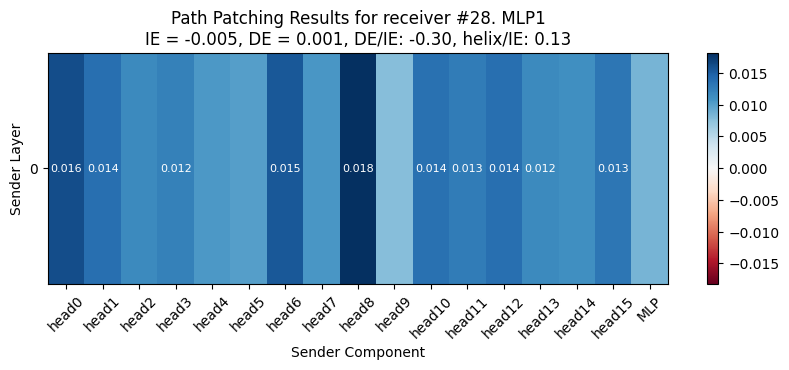

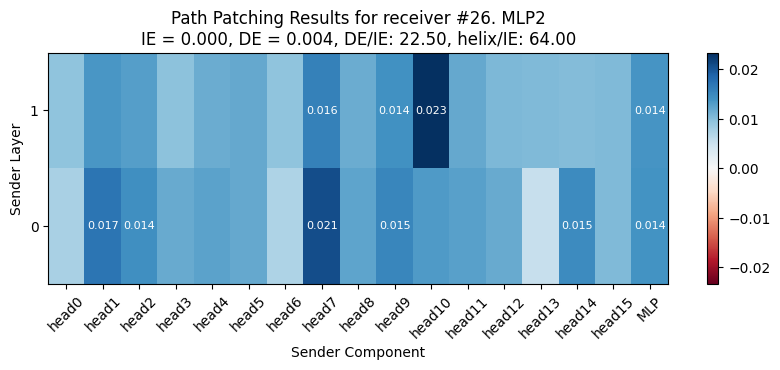

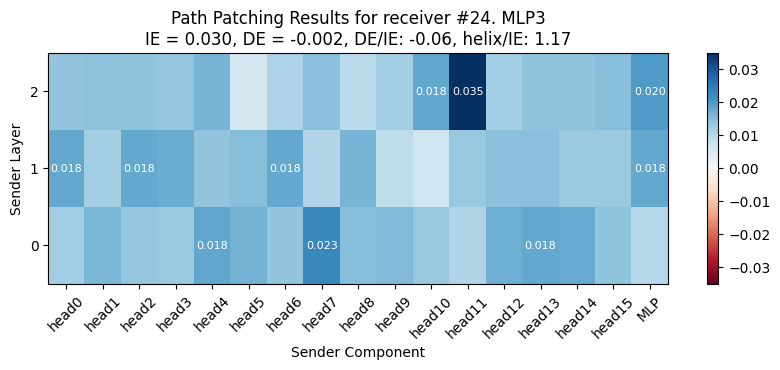

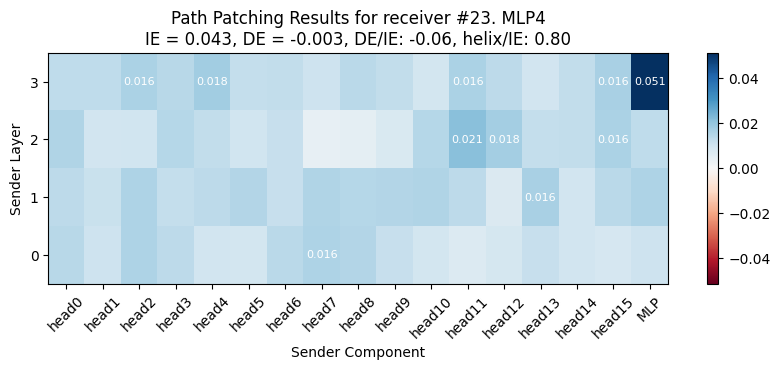

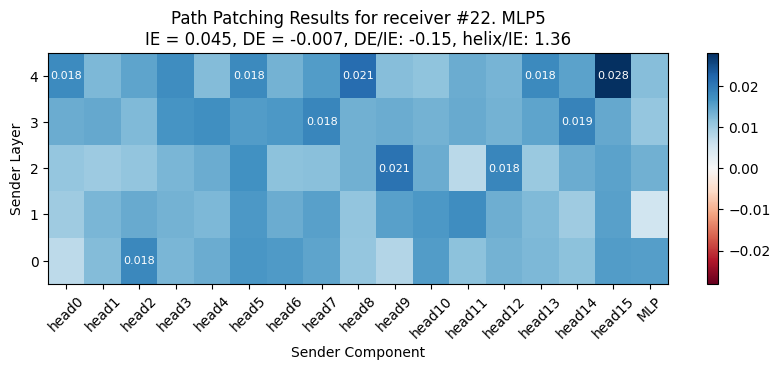

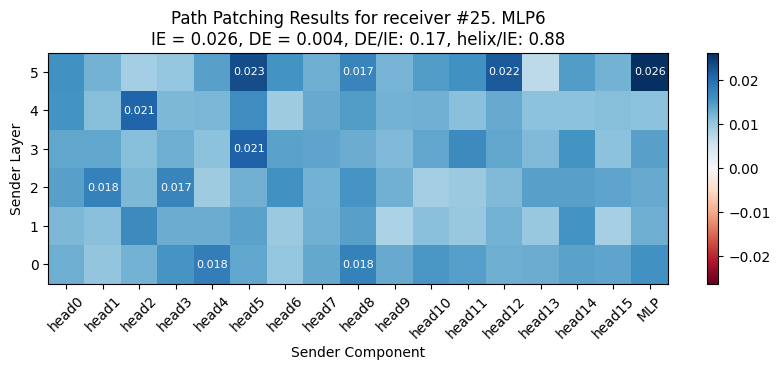

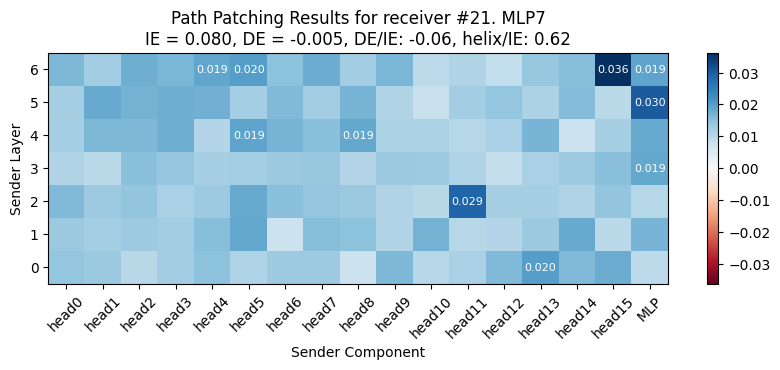

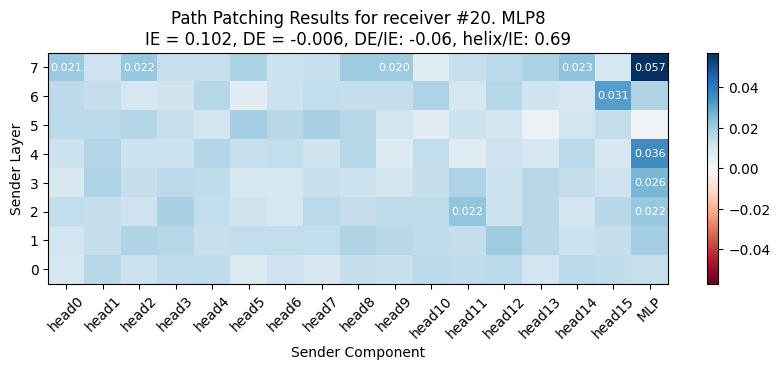

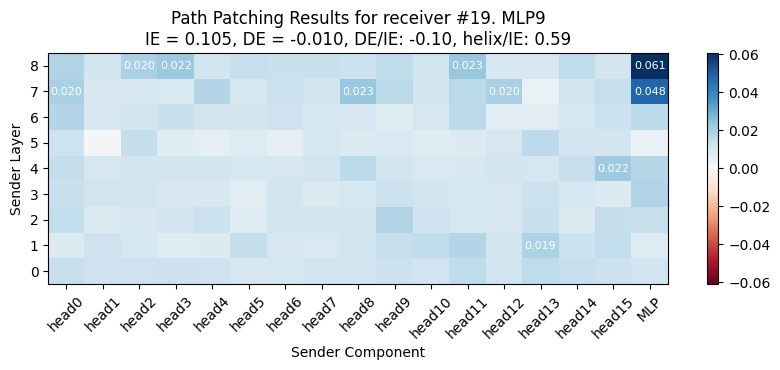

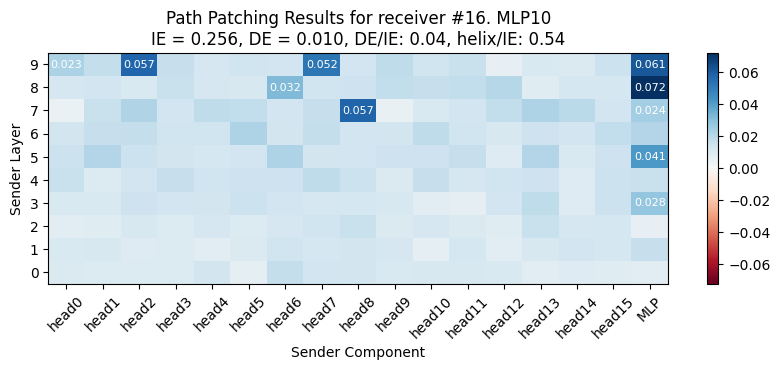

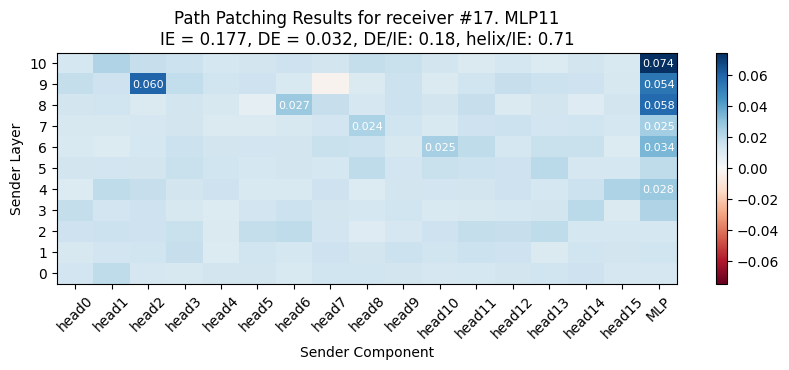

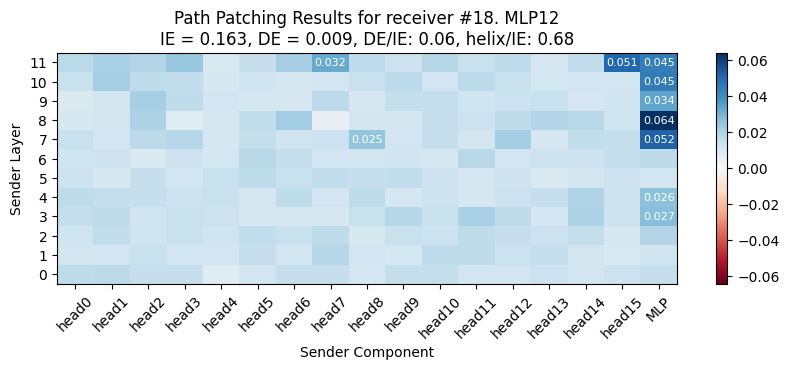

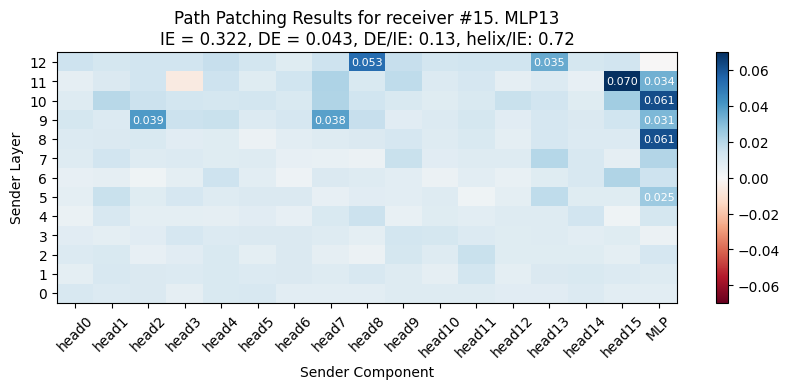

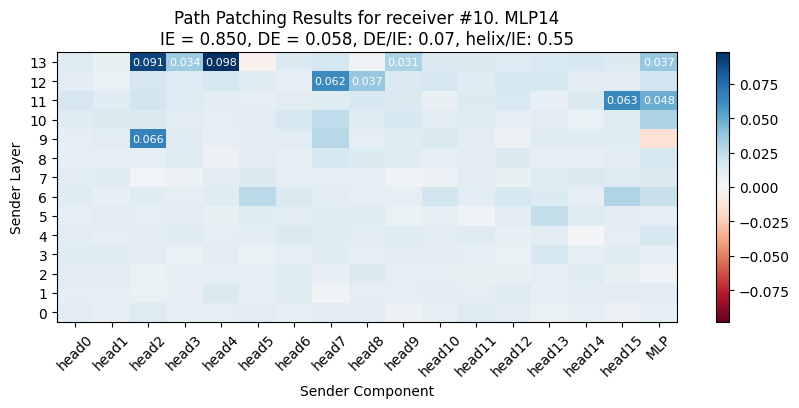

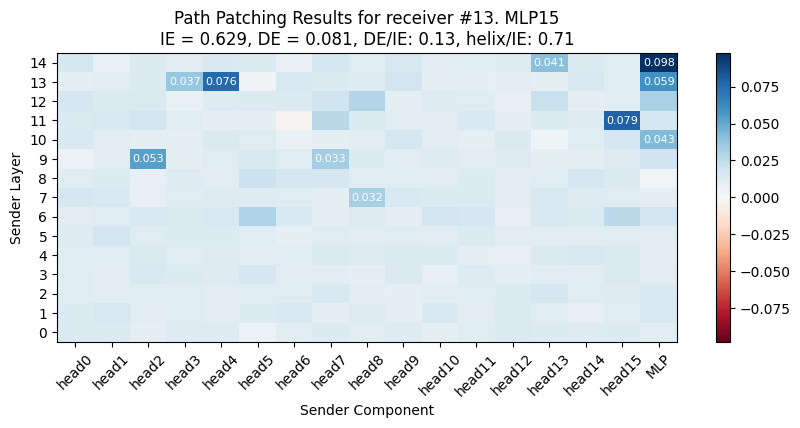

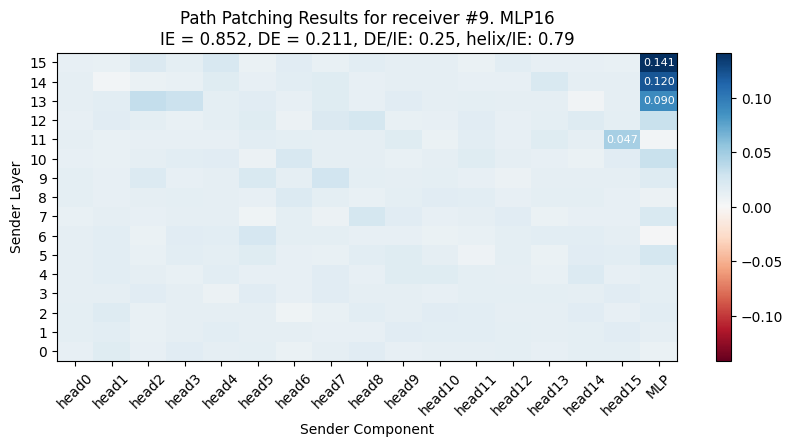

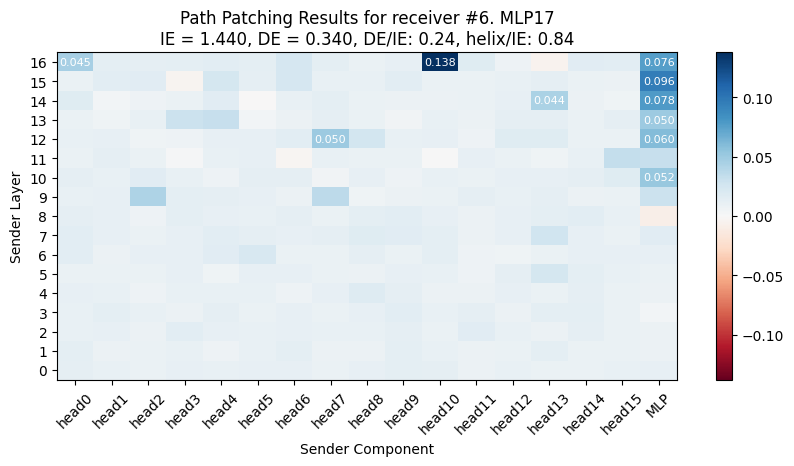

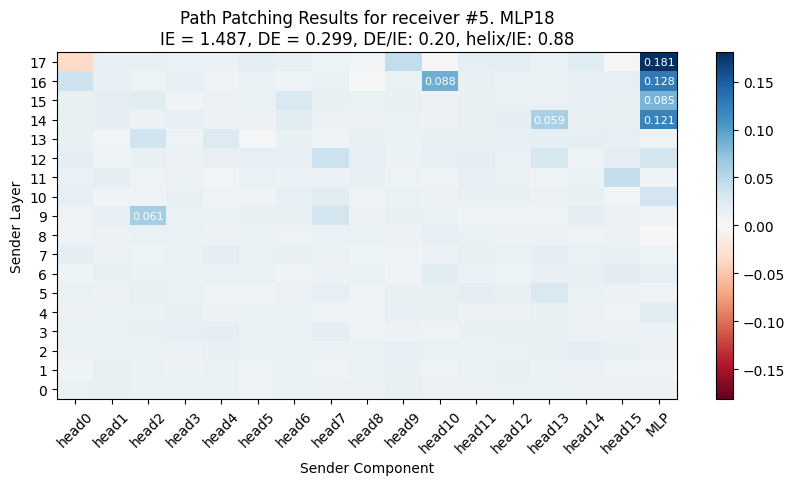

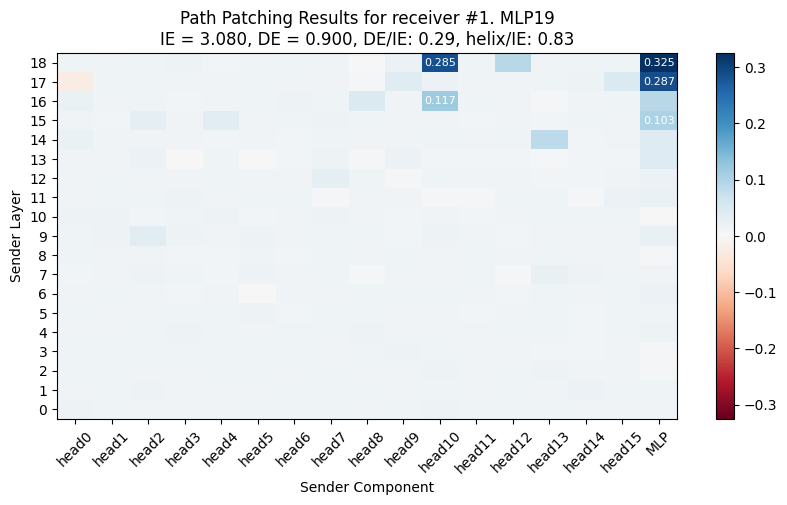

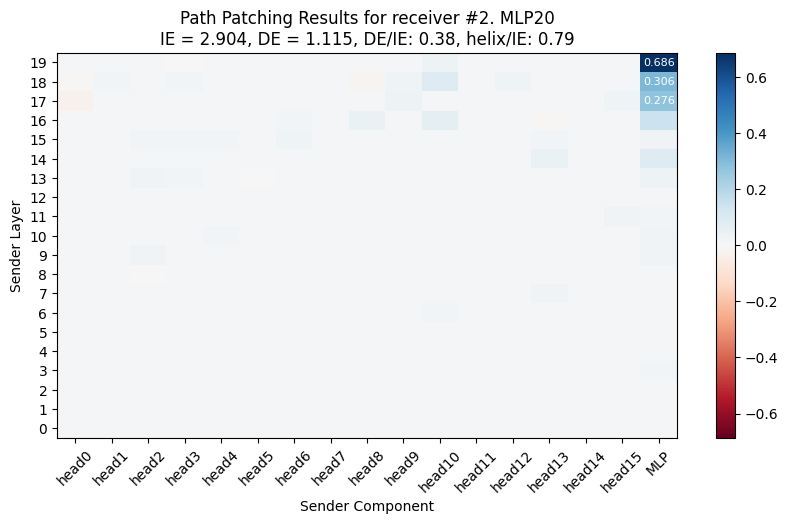

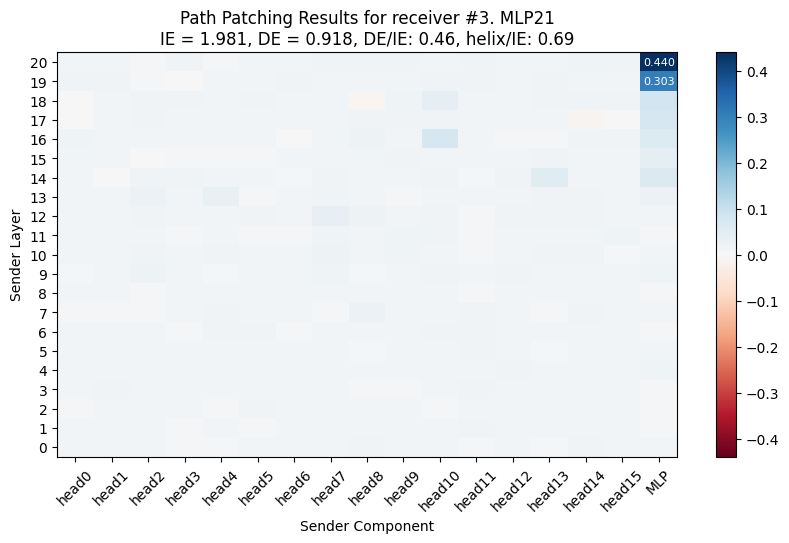

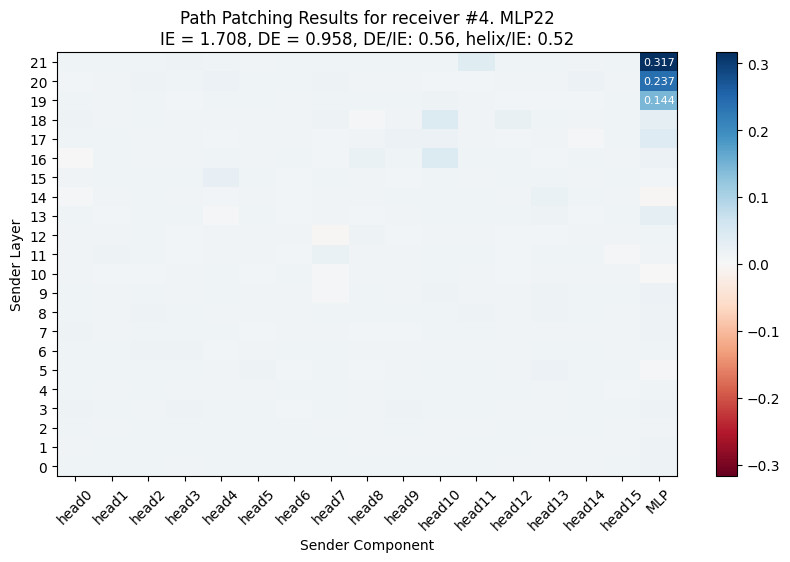

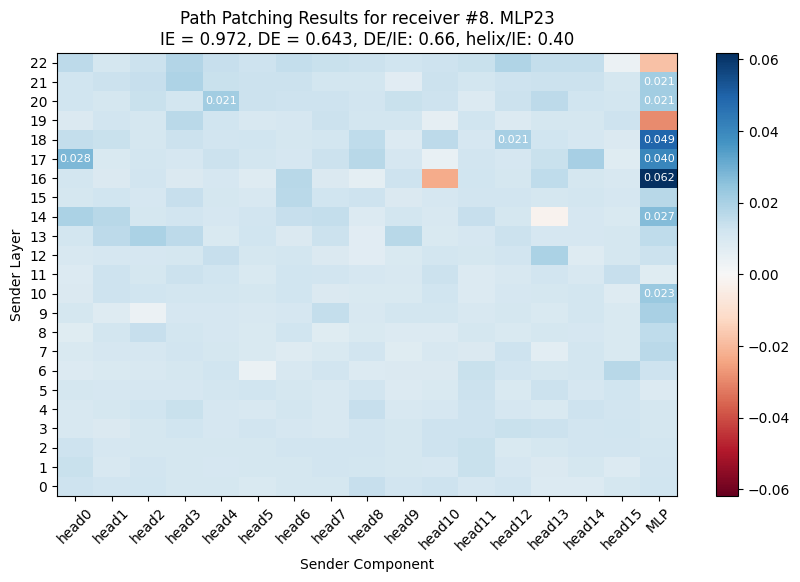

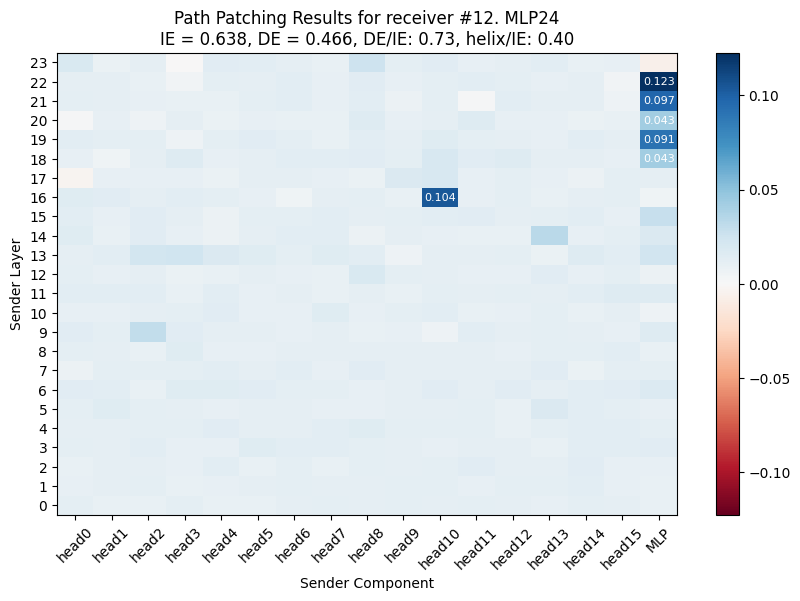

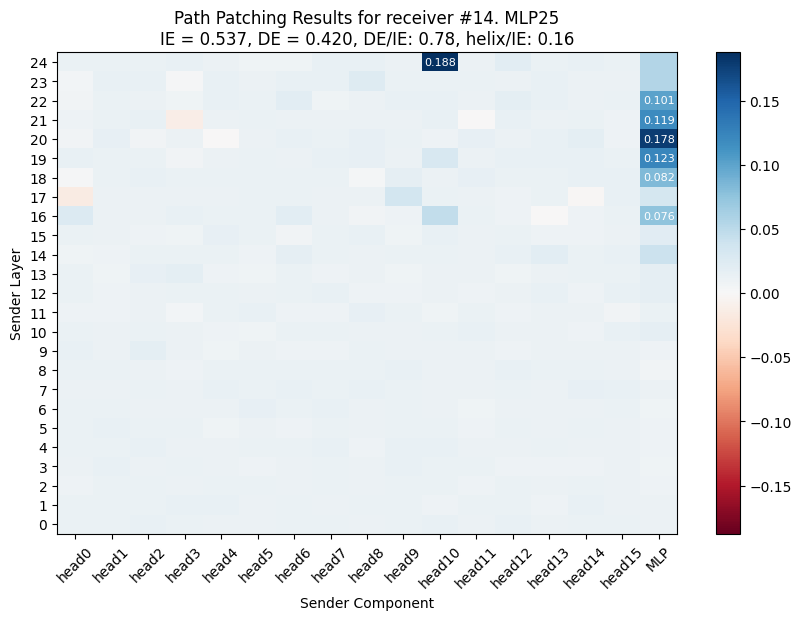

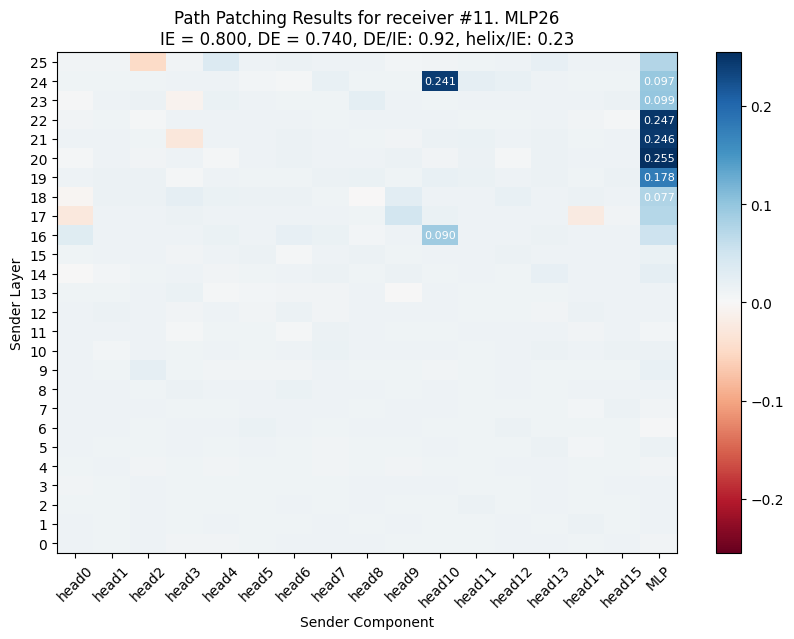

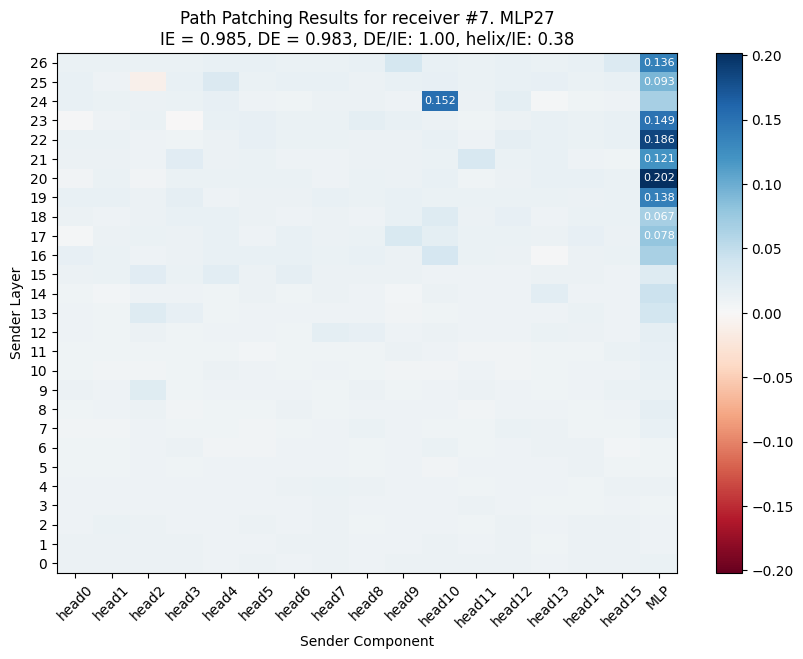

In [85]:
def plot_pathpatch(layer_global, fixed = 'sender'):
    # Read in data
    save_path = f"data_addition/ab_mlps/path_patching/{fixed}_fixed/L{layer_global}.pkl"
    with open(save_path, 'rb') as f:
        results = pickle.load(f)
    helix_act, _,full_act, full_path = get_intervention_results('helix_ab')
    target_value = full_act[layer_global]
    sorted_values = np.sort(full_act)[::-1]  # Sort in descending order
    layer_rank = np.where(sorted_values == target_value)[0][0] + 1  # Add 1 to convert from 0-based to 1-based ranking
    ie,de, helix = full_act[layer_global], full_path[layer_global], helix_act[layer_global]
    de_ie = de/ie if ie!=0 else 0
    helix_ratio = helix/ie if ie!=0 else 0

    # Find min layer in results
    min_layer = float('inf')
    max_layer = -float('inf')
    for receiver_node in results.keys():
        if not isinstance(receiver_node, tuple):
            min_layer = min(min_layer,int(receiver_node))
            max_layer = max(max_layer, int(receiver_node))
    n_rows = max_layer - min_layer + 1
    matrix = np.zeros((n_rows, NHEADS + 1)) # +1 for MLP column
    for key, value in results.items():
        if isinstance(key, tuple): # attn head
            layer, head = key
            matrix[layer - min_layer, head] = value
            
        else: # mlp 
            matrix[key - min_layer, -1] = value
            
            
    # Create labels
    x_labels = [f'head{i}' for i in range(NHEADS)] + ['MLP']
    y_labels = list(range(min_layer, max_layer+1))
    
    # Plot
    plt.figure(figsize=(10,max(n_rows/4, 3)))
    vmax = max(abs(matrix.min()), abs(matrix.max()))
    im = plt.imshow(matrix[::-1], cmap='RdBu', aspect='auto', vmin=-vmax, vmax=vmax, origin='upper')
    plt.colorbar(im)
    
    # Find top 10 values and their positions
    flat_indices = np.argsort(matrix.ravel())[-10:]  # Get indices of top 10 values
    row_indices, col_indices = np.unravel_index(flat_indices, matrix.shape)
    top_values = matrix[row_indices, col_indices]
    
    # Annotate values > 0.3*vmax
    for row, col, val in zip(row_indices, col_indices, top_values):
        if val > 0.3 * vmax:
            plt.text(col, n_rows-1-row, f'{val:.3f}', ha='center', va='center', color='white', fontsize = 8)
    
    plt.xticks(range(NHEADS + 1), x_labels, rotation=45)
    plt.yticks(range(n_rows), y_labels[::-1])  # Reverse y labels
    
    plt.title(f'Path Patching Results for {fixed} #{layer_rank}. MLP{layer_global}\nIE = {ie:.3f}, DE = {de:.3f}, DE/IE: {de_ie:.2f}, helix/IE: {helix_ratio:.2f}')
    opposite = 'Receiver' if fixed == 'sender' else 'Sender'
    plt.xlabel(f'{opposite} Component')
    plt.ylabel(f'{opposite} Layer')
    
    # Save plot
    save_dir = f"figs_addition/ab_attn_heads/path_patching/{fixed}_fixed"
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/L{layer_global}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

def plot_all_path_patch(fixed = 'sender'):
    for layer in range(1,NLAYERS):
        plot_pathpatch(layer,fixed = fixed)
#plot_pathpatch(14, fixed = 'receiver')
plot_all_path_patch('receiver')